## Проект e-commerce: вариант 1 

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут=[https://vc.ru/s/productstar/134090-chto-takoe-kogortnyy-analiz]. (10 баллов)

6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). Описание подхода можно найти тут=[https://medianation.ru/blog/analitika/avtomatizatsiya-rfm-analiza-kak-segmentirovat-klientskuyu-bazu-na-python/]. (35 баллов)

Файлы:

 olist_customers_dataset.csv — таблица с уникальными идентификаторами пользователей
    
    customer_id — позаказный идентификатор пользователя (аналог номера паспорта)

    customer_unique_id —  уникальный идентификатор пользователя

    customer_zip_code_prefix —  почтовый индекс пользователя

    customer_city —  город доставки пользователя

    customer_state —  штат доставки пользователя


olist_orders_dataset.csv —  таблица заказов
    
    order_id —  уникальный идентификатор заказа (номер чека)

    customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)

    order_status —  статус заказа

    order_purchase_timestamp —  время создания заказа

    order_approved_at —  время подтверждения оплаты заказа

    order_delivered_carrier_date —  время передачи заказа в логистическую службу

    order_delivered_customer_date —  время доставки заказа

    order_estimated_delivery_date —  обещанная дата доставки


olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
    
    order_id —  уникальный идентификатор заказа (номер чека)

    order_item_id —  идентификатор товара внутри одного заказа

    product_id —  ид товара (аналог штрихкода)

    seller_id — ид производителя товара

    shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

    price —  цена за единицу товара

    freight_value —  вес товара


— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5


Уникальный статусы заказов в таблице olist_order_items_dataset:

    created —  создан
    approved —  подтверждён
    invoiced —  выставлен счёт
    processing —  в процессе сборки заказа
    shipped —  отгружен со склада
    delivered —  доставлен пользователю
    unavailable —  недоступен
    canceled —  отменён

In [1]:
import pandas as pd
import numpy as np
import from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


    customer_id — позаказный идентификатор пользователя (аналог номера паспорта)

    customer_unique_id —  уникальный идентификатор пользователя

    customer_zip_code_prefix —  почтовый индекс пользователя

    customer_city —  город доставки пользователя

    customer_state —  штат доставки пользователя

In [3]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [4]:
df_customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [5]:
df_customers.customer_unique_id.nunique()/df_customers.customer_unique_id.count() * 100

96.63619633752677

96.6% пользователей сделали покупку только 1 раз

зарузим и изучим данные по заказам

In [6]:
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


    order_id —  уникальный идентификатор заказа (номер чека)

    customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)

    order_status —  статус заказа

    order_purchase_timestamp —  время создания заказа

    order_approved_at —  время подтверждения оплаты заказа

    order_delivered_carrier_date —  время передачи заказа в логистическую службу

    order_delivered_customer_date —  время доставки заказа

    order_estimated_delivery_date —  обещанная дата доставки

In [7]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [8]:
df_orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [9]:
#приведем даты к типу дата
date_columns = ['order_purchase_timestamp', 
                'order_approved_at', 
                'order_delivered_carrier_date', 
                'order_delivered_customer_date', 
                'order_estimated_delivery_date']
for col in date_columns:
    df_orders[col] = pd.to_datetime(df_orders[col], format='%Y-%m-%d %H:%M:%S')
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [10]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [11]:
#посмотрим пропуски в данных
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

добавим в данные колонки с годом и месяцем покупок

In [12]:
df_orders['order_purchase_year'] = pd.DatetimeIndex(df_orders.order_purchase_timestamp).year

In [13]:
df_orders['order_purchase_month'] = pd.DatetimeIndex(df_orders.order_purchase_timestamp).month

далее среди недоставленных выберем только те, что были подтверждены и оплачены   
`order_approved_at` - если есть дата, значит заказ подтвержден и оплачен

In [14]:
# недоставленные заказы == нет даты доставки
df_orders_not_delivered = df_orders.loc[df_orders['order_delivered_customer_date'].isna() & df_orders['order_approved_at'].notna()]

In [15]:
df_orders_not_delivered.notna().sum()

order_id                         2819
customer_id                      2819
order_status                     2819
order_purchase_timestamp         2819
order_approved_at                2819
order_delivered_carrier_date     1183
order_delivered_customer_date       0
order_estimated_delivery_date    2819
order_purchase_year              2819
order_purchase_month             2819
dtype: int64

чтобы посмотреть сколько заказов в среднем в месяц не доставляется, сделаем группировку по году и месяцу заказа и посчитаем количество заказов в каждом месяце, далее возьмем среднее

In [231]:
df_orders_not_delivered.groupby(['order_purchase_year', 'order_purchase_month'])\
                       .agg({'order_id' : 'count'})\
                       .rename(columns={'order_id' : 'count_orders'})\
                       .mean()

count_orders    122.565217
dtype: float64

в среднем примерно 123 заказа в месяц не доставляется

посмотрим статусы заказов, у которых нет даты фактической доставки. считаем среднее количество таких заказов по каждому статусу

In [17]:
df_df_orders_not_delivered.groupby(['order_purchase_year', 'order_purchase_month', 'order_status'])\
                                                               .agg({'customer_id' : 'count'})\
                                                               .rename(columns={'customer_id' : 'count_orders'})\
                                                               .groupby('order_status')\
                                                               .mean()

,count_orders
order_status,
approved,1.000000
canceled,21.727273
delivered,2.000000
invoiced,14.952381
processing,15.842105
shipped,48.130435
unavailable,29.000000


    created —  создан
    approved —  подтверждён
    invoiced —  выставлен счёт
    processing —  в процессе сборки заказа
    shipped —  отгружен со склада
    delivered —  доставлен пользователю
    unavailable —  недоступен
    canceled —  отменён

загрузим данные по товарам и изучим их

In [18]:
df_order_items = pd.read_csv('olist_order_items_dataset.csv', )
df_order_items['shipping_limit_date'] = pd.to_datetime(df_order_items['shipping_limit_date'], format='%Y-%m-%d %H:%M:%S')
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


    order_id —  уникальный идентификатор заказа (номер чека)

    order_item_id —  идентификатор товара внутри одного заказа

    product_id —  ид товара (аналог штрихкода)

    seller_id — ид производителя товара

    shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

    price —  цена за единицу товара

    freight_value —  вес товара

In [19]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [20]:
df_order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

за покупку будем считать заказы, которые состоялись, учитываем только заказы, которые подтверждены и оплачены и исключим заказы со статусом `unavailable`, `canceled`

In [21]:
df_orders_select = df_orders.loc[~df_orders['order_status'].isin(['unavailable', 'canceled']) 
                                  & df_orders['order_approved_at'].notna()]

In [22]:
df_order_items = df_orders_select.merge(df_order_items, on='order_id')

добавим в данны колонку с названием дня недели покупки

In [23]:
df_order_items['day_name'] = df_order_items['order_purchase_timestamp'].dt.day_name()

In [24]:
#считаем количество покупок по дням для каждого товара
df_group_prod_day_count = df_order_items.groupby(['product_id', 'day_name'], as_index=False)\
                                        .agg({'order_item_id': 'count'})\
                                        .rename(columns={'order_item_id':'count'})
                
#считаем максимальное число покупок в день по каждому товару
df_max_count_prod = df_group_prod_day_count.groupby(['product_id'], as_index=False)\
                                            .agg({'count':'max'})\
                                            .rename(columns={'count':'max_count'})

In [25]:
#теперь формируем датафрем, где видно максимальное количество покупок и в какой день для каждого товара
df_max_count_prod.merge(df_group_prod_day_count, how='left', left_on='product_id', right_on='product_id')\
                 .query('max_count == count')\
                 .drop(columns=['count'])

,product_id,max_count,day_name
0,00066f42aeeb9f3007548bb9d3f33c38,1,Sunday
1,00088930e925c41fd95ebfe695fd2655,1,Tuesday
2,0009406fd7479715e4bef61dd91f2462,1,Thursday
3,000b8f95fcb9e0096488278317764d19,1,Friday
4,000b8f95fcb9e0096488278317764d19,1,Wednesday
...,...,...,...
60873,fff6177642830a9a94a0f2cba5e476d1,1,Sunday
60874,fff81cc3158d2725c0655ab9ba0f712c,1,Monday
60875,fff9553ac224cec9d15d49f5a263411f,1,Friday
60879,fffdb2d0ec8d6a61f0a0a0db3f25b441,2,Tuesday


In [26]:
#посмотрим на товары с более, чем 1 максимальной покупкой
df_max_count_prod.merge(df_group_prod_day_count, how='left', left_on='product_id', right_on='product_id')\
                 .query('max_count == count & max_count > 1')

,product_id,max_count,day_name,count
7,00126f27c813603687e6ce486d909d01,2,Sunday,2
9,001795ec6f1b187d37335e1c4704762e,3,Saturday,3
19,001b72dfd63e9833e8c02742adf472e3,5,Wednesday,5
23,00210e41887c2a8ef9f791ebc780cc36,3,Thursday,3
26,002159fe700ed3521f46cfcf6e941c76,2,Saturday,2
...,...,...,...,...
60862,ffedbd68fa6f44e788ff6c2db8094715,3,Tuesday,3
60863,ffef256879dbadcab7e77950f4f4a195,2,Monday,2
60865,ffef256879dbadcab7e77950f4f4a195,2,Tuesday,2
60868,fff0a542c3c62682f23305214eaeaa24,4,Tuesday,4


4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [130]:
df_customers_orders = df_customers.merge(df_orders_select, on='customer_id')

In [28]:
#добавим колонку с количеством недель в месяце (число дней деленное на 7)
df_customers_orders['week_in_month'] = df_customers_orders.order_purchase_timestamp.dt.daysinmonth / 7
df_customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,week_in_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017,5,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018,1,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018,5,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018,3,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018,7,4.428571


In [29]:
df_customers_orders_counts = df_customers_orders.groupby(['customer_unique_id', 'order_purchase_year', 'order_purchase_month'], as_index=False)\
                                       .agg({'customer_id':'count'})\
                                       .rename(columns={'customer_id':'count_orders'})
df_customers_orders_counts.head()

,customer_unique_id,order_purchase_year,order_purchase_month,count_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,5,1
2,0000f46a3911fa3c0805444483337064,2017,3,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017,10,1
4,0004aac84e0df4da2b147fca70cf8255,2017,11,1


In [30]:
df_customers_orders = df_customers_orders.merge(df_customers_orders_counts, on=['customer_unique_id', 'order_purchase_year', 'order_purchase_month'])
df_customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,week_in_month,count_orders
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017,5,4.428571,1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018,1,4.428571,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018,5,4.428571,1
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018,3,4.428571,1
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018,7,4.428571,1


In [31]:
df_customers_orders['mean_orders_per_week_on_month'] = df_customers_orders.count_orders / df_customers_orders.week_in_month
df_customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,week_in_month,count_orders,mean_orders_per_week_on_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017,5,4.428571,1,0.225806
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018,1,4.428571,1,0.225806
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018,5,4.428571,1,0.225806
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018,3,4.428571,1,0.225806
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018,7,4.428571,1,0.225806


5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут=[https://vc.ru/s/productstar/134090-chto-takoe-kogortnyy-analiz]. (10 баллов)

In [46]:
import numpy as np

In [54]:
def cohort_analize(df, client_col='customer_unique_id', order_col='order_id', timestamp='order_purchase_timestamp', heatmap=True):
    
    df_customers_first_order_date = df.groupby(client_col, as_index=False)\
                                     .agg({timestamp:'min'})\
                                     .rename(columns={timestamp:'first_order_date'}) 
    df = df.merge(df_customers_first_order_date, on=client_col)
     
    df['first_order_date'] = df['first_order_date'].dt.to_period("M")
    df['order_date'] = df[timestamp].dt.to_period("M")
    
    df_cohort = df.groupby(['first_order_date', 'order_date', client_col], as_index=False)\
                  .agg({order_col:'count'})\
                  .rename(columns={order_col: 'count'})
    cohort = df_cohort.groupby(['first_order_date', 'order_date'])\
                      .agg({client_col : 'count'})\
                      .rename(columns={client_col : 'count'})
        
    def cohort_period(df_):
        df_['cohort_period'] = np.arange(len(df_))
        return df_

    cohort = cohort.groupby(level=0).apply(cohort_period)
    
    cohort_group_size = cohort['count'].groupby(level=0).first()
    cohort['count'] = pd.DataFrame(cohort['count'] / cohort_group_size)
    cohort.rename(columns={'count' : 'retention'}, inplace=True)
    cohort.reset_index(inplace=True)
    
    cohort = cohort.pivot(index='first_order_date', columns='cohort_period', values='retention')
    
    cohort.fillna(0, inplace=True)
    
    if heatmap:
        sns.set(style='ticks')
        plt.figure(figsize=(24, 16))
        plt.title('Cohorts: User Retention')

        sns.heatmap(cohort, mask=cohort.isin([0]), annot=True, fmt='.3%');
        
    return cohort

для анализа нужен только 1 целый год - 2017 в данном случае

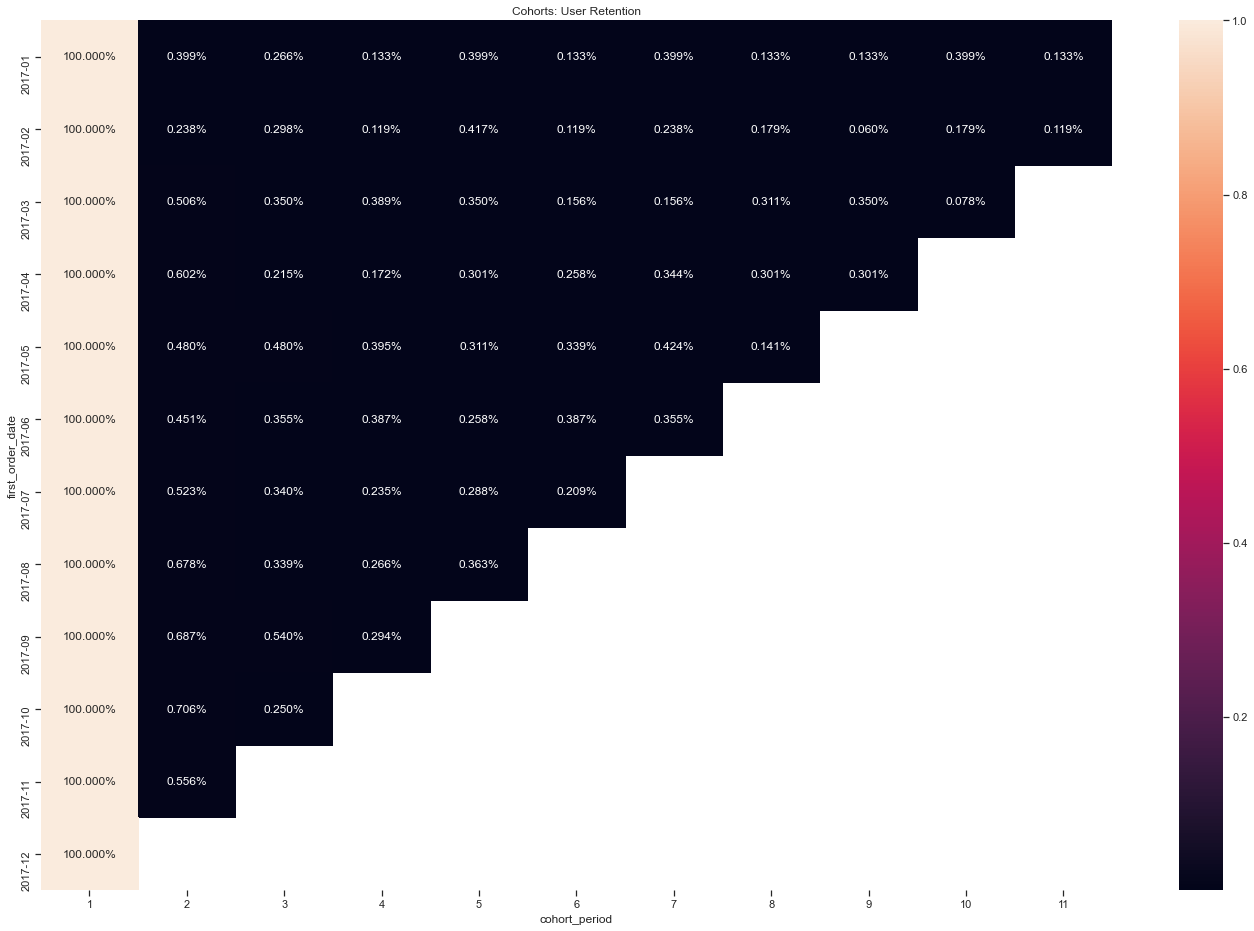

In [235]:
Cohort = cohort_analize(df_customers_orders[df_customers_orders['order_purchase_year'] == 2017].copy())

In [236]:
Cohort

cohort_period,1,2,3,4,5,6,7,8,9,10,11
first_order_date,,,,,,,,,,,
2017-01,1.0,0.003995,0.002663,0.001332,0.003995,0.001332,0.003995,0.001332,0.001332,0.003995,0.001332
2017-02,1.0,0.002384,0.002980,0.001192,0.004172,0.001192,0.002384,0.001788,0.000596,0.001788,0.001192
2017-03,1.0,0.005056,0.003501,0.003890,0.003501,0.001556,0.001556,0.003112,0.003501,0.000778,0.000000
2017-04,1.0,0.006019,0.002150,0.001720,0.003009,0.002580,0.003439,0.003009,0.003009,0.000000,0.000000
2017-05,1.0,0.004801,0.004801,0.003954,0.003106,0.003389,0.004236,0.001412,0.000000,0.000000,0.000000
2017-06,1.0,0.004513,0.003546,0.003868,0.002579,0.003868,0.003546,0.000000,0.000000,0.000000,0.000000
2017-07,1.0,0.005231,0.003400,0.002354,0.002877,0.002093,0.000000,0.000000,0.000000,0.000000,0.000000
2017-08,1.0,0.006780,0.003390,0.002663,0.003632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-09,1.0,0.006869,0.005397,0.002944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


вычислим когорту с максимальной retention за 3-й месяц:

In [237]:
Cohort[4].idxmax()

Period('2017-05', 'M')

6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). Описание подхода можно найти тут=[https://medianation.ru/blog/analitika/avtomatizatsiya-rfm-analiza-kak-segmentirovat-klientskuyu-bazu-na-python/ ]. (35 баллов)

In [68]:
df_order_price = df_order_items.groupby('order_id', as_index=False)\
                               .agg({'price' : 'sum'})

In [131]:
df_customers_orders

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017,5
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018,5
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018,3
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98183,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,2018,4
98184,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,2018,4
98185,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,2018,4
98186,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,2017,11


In [153]:
df_customers_orders['order_purchase_timestamp'] = pd.to_datetime(df_customers_orders['order_purchase_timestamp'].dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [159]:
df_for_rfm = df_customers_orders.merge(df_order_price, on='order_id')
df_for_rfm

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,price
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017,5,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018,1,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018,5,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018,3,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018,7,230.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98180,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,2018,4,74.90
98181,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,2018,4,114.90
98182,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,2018,4,37.00
98183,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,2017,11,689.00


вместо текущей даты будем использовать max + 1.   
Для создания recency, frequency и monetary мы сгруппируем наши записи по customer_unique_id.

* `Recency` — разница между текущей датой и датой последнего платежа (считаем разницу между последней датой покупки и текущей)
* `Frequency` — количество транзакций (считаем количество заказов)
* `Monetary` — сумма покупок (суммируем стоимость заказов)

In [161]:
last_date = df_for_rfm['order_purchase_timestamp'].max() + timedelta(days=1)
rfmTable = df_customers_orders_items.groupby('customer_unique_id')\
                                      .agg({'order_purchase_timestamp': lambda x: (last_date - x.max()).days,
                                            'order_id': lambda x: len(x), 
                                            'price': lambda x: x.sum()})

rfmTable.rename(columns={'order_purchase_timestamp': 'recency', 
                          'order_id': 'frequency', 
                          'price': 'monetary_value'}, inplace=True)

rfmTable

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
0000f46a3911fa3c0805444483337064,542,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00
fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
ffff371b4d645b6ecea244b27531430a,573,1,89.90


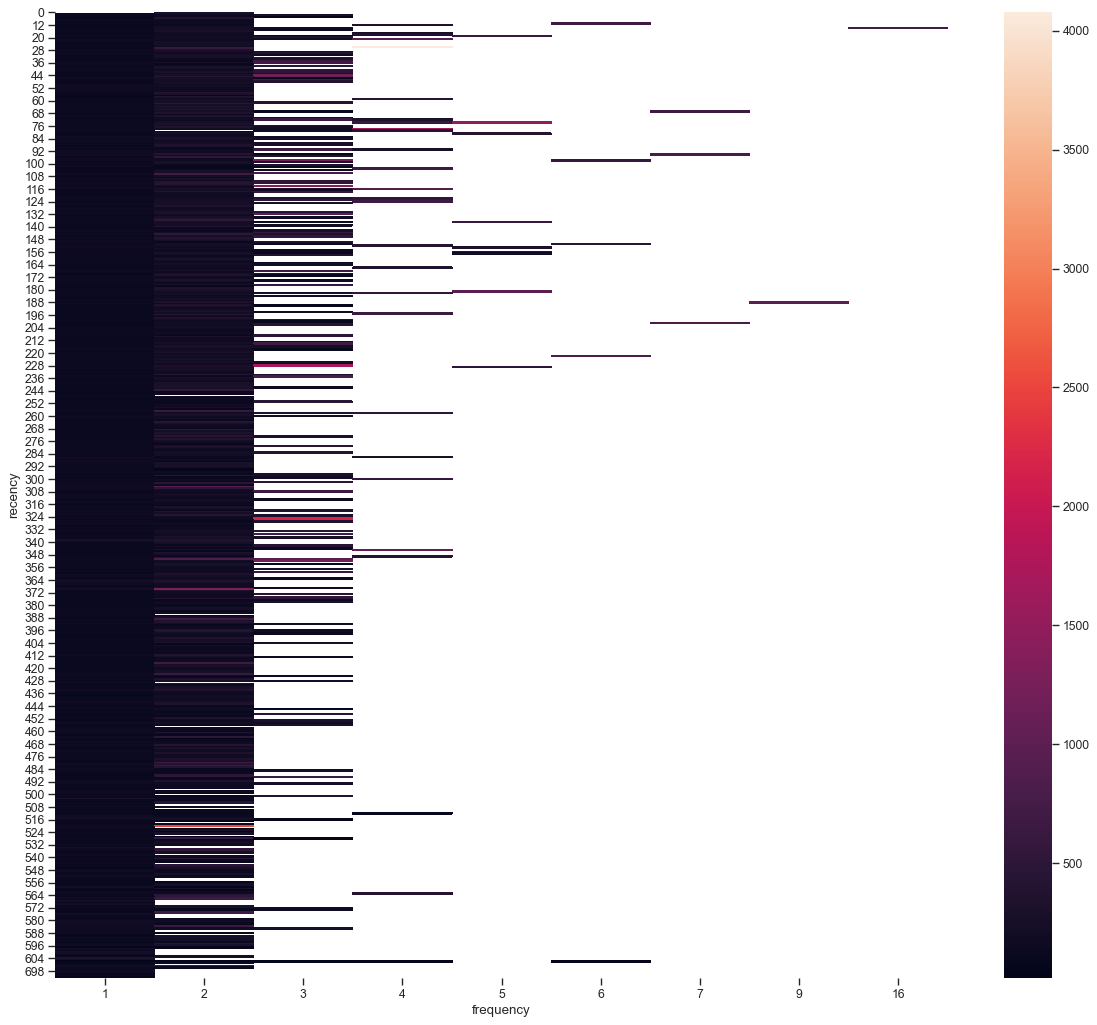

In [198]:
table = rfmTable.pivot_table(index='recency',
                            columns='frequency',
                            values='monetary_value')
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(table)

по данным и раньше было видно, что в основном наши покупатели покупали 1 раз, но сейчас это наглядно на тепловой карте. в основном наши покупатели делали 1 заказ.

разобьем данные по квантилям на диапазон от 1 до 4.

In [194]:
quantiles = rfmTable.quantile(q=[0.25, 0.50, 0.75])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable

def RScore(x,p,d):
     if x <= d[p][0.25]:
         return 1
     elif x <= d[p][0.50]:
         return 2
     elif x <= d[p][0.75]: 
         return 3
     else:
         return 4

segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(RScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(RScore, args=('monetary_value',quantiles,))
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,1,3,113
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,1,1,111
0000f46a3911fa3c0805444483337064,542,1,69.00,4,1,2,412
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,1,1,311
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,3,1,4,314


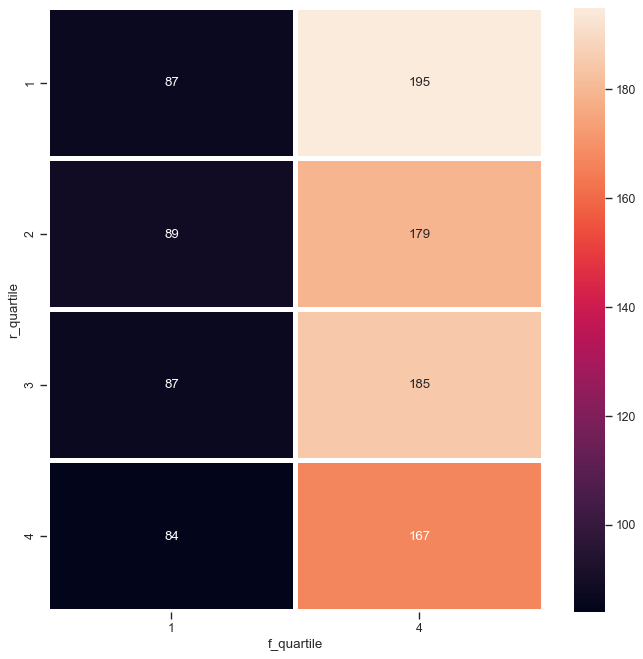

In [196]:
rfm_seg_table = segmented_rfm.pivot_table(index='r_quartile',
                                        columns='f_quartile',
                                        values='monetary_value',
                                        aggfunc=np.median).applymap(int)
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(rfm_seg_table, annot=True, linewidths=3, fmt='.0f')

In [197]:
segmented_rfm.groupby('RFMScore')\
             .agg({'recency' : 'mean',
                   'frequency' : 'mean',
                   'monetary_value' : 'mean'})

,recency,frequency,monetary_value
RFMScore,,,
111,61.752977,1.000000,29.260946
112,60.638855,1.000000,65.869958
113,63.703917,1.000000,118.449257
114,63.563777,1.000000,363.963827
141,58.535714,2.000000,36.253571
142,66.455446,2.039604,70.399901
143,61.672515,2.040936,121.009415
144,63.705882,2.229412,380.833294
211,173.348100,1.000000,29.438475
